In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib.lines import Line2D
from calendar import month_name

from ipywidgets import widgets
from ipywidgets import interactive
from ipywidgets import GridspecLayout,Box,Layout
from IPython.display import display


# PARAMETERS

In [2]:
area = 4317 
delta = 0.10 # as a % of consumption [%]

# CONSUMPTION DATA

In [3]:
# Consumption data loading and processing

dados_consumo=pd.read_csv("dados/dados_consumo.csv", sep=";", header=None)
dados_consumo.rename({0:'Date',
           1:'Month',
           2:'Cons'},axis=1,inplace=True)

dados_consumo.index=pd.to_datetime(dados_consumo['Date'])
dados_consumo.drop('Date',axis=1,inplace=True)
dados_consumo.drop('Month',axis=1,inplace=True)
dados_consumo['Cons']=dados_consumo['Cons'].str.replace(',','.')
dados_consumo['Cons']=dados_consumo['Cons'].astype(float)
dados_consumo=dados_consumo.resample('1h').sum()
dados_consumo['Cons']=dados_consumo['Cons'].resample('1h').sum()

dados_consumo.loc[dados_consumo.index=='2018-02-28','Cons'] = dados_consumo['Cons'].mean() # outlier

# sOLAR DATA

In [4]:
# Irradiation data loading and processing

dados_irradiacao=pd.read_csv("dados/dados_irradiacao.csv", sep=";")
dados_irradiacao['Irradiacao']=dados_irradiacao['Irradiacao'].str.replace(',','.').astype(float)

In [5]:
# Function that computes the energy generated by a PV panel
def PV_out(dados_irradiacao):
    dados_irradiacao['PV_Out']=dados_irradiacao['Irradiacao']*0.15*0.95*area
    return dados_irradiacao

Text(0, 0.5, 'Irradiation [kWh]')

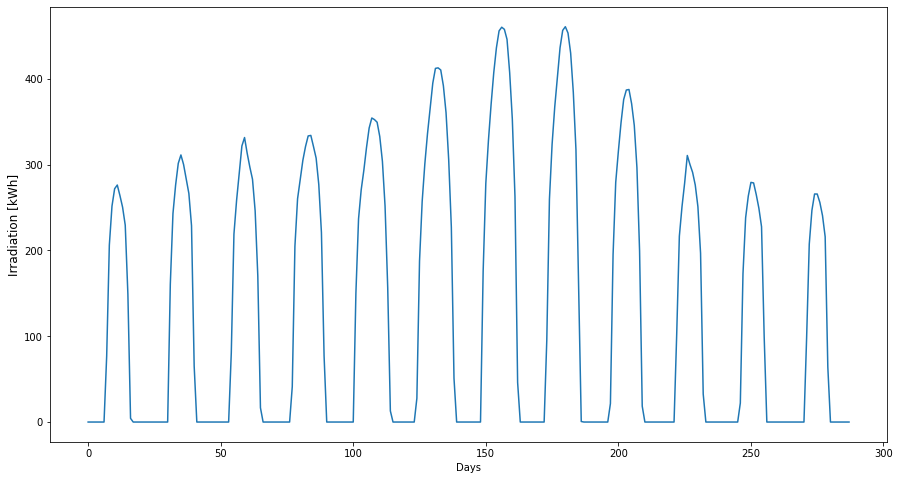

In [6]:
PV_out(dados_irradiacao)
dados_irradiacao['PV_Out'].plot()

plt.gcf().set_size_inches(15, 8) # Figure's size
plt.xlabel("Days")
plt.ylabel("Irradiation [kWh]",fontsize='large')

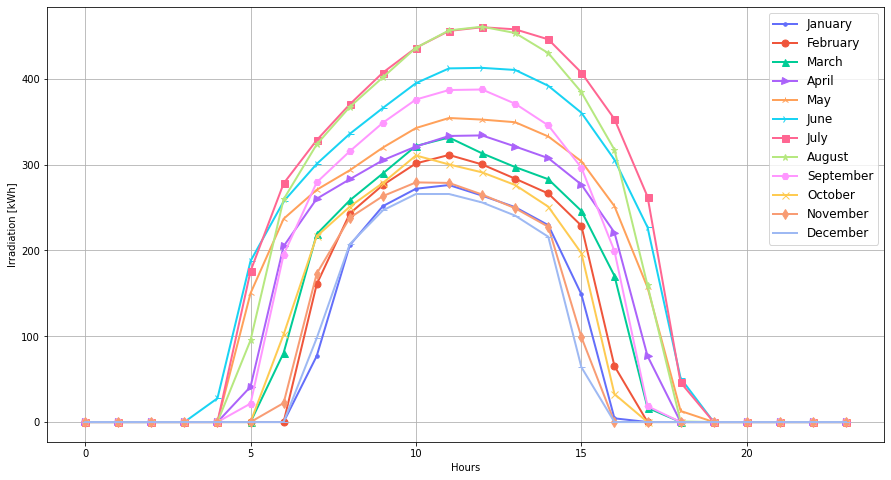

In [7]:
# Monthly view of above graph
months = dados_irradiacao["mês"].unique()

# Choose 12 unique markers and colors
markers = [marker for i,marker in enumerate(Line2D.markers) if i%2 == 0][:12]
colors = ['#636EFA','#EF553B','#00CC96','#AB63FA','#FFA15A',
            '#19D3F3','#FF6692','#B6E880','#FF97FF','#FECB52','#f89c74', '#9eb9f3']


plt.gcf().set_size_inches(15, 8)
for i,month in enumerate(range(12)):

    # Select PV Output rows affected to i-th month
    row_mask = dados_irradiacao["mês"] == months[i]

    y = dados_irradiacao.loc[row_mask,"PV_Out"]

    plt.plot(range(24),y ,linestyle='-', linewidth=2,marker = markers[i],markersize = 7,label = month_name[i+1],color = colors[i],)
    plt.legend(fontsize='large', fancybox=True)

plt.ylabel("Irradiation [kWh]")
plt.xlabel("Hours")
plt.grid()
plt.show()

In [8]:
for i,row in dados_consumo.iterrows():
    dados_consumo.loc[i,'Irradiacao']=dados_irradiacao.loc[(dados_irradiacao.hora==i.hour) & (dados_irradiacao.mês==dados_irradiacao['mês'].unique()[i.month-1]),'Irradiacao'].values[0]
dados_consumo = PV_out(dados_consumo)

# SURPLUS

In [9]:
dados_consumo['Cons'] = dados_consumo['Cons']*delta 
dados_consumo['Surplus'] = dados_consumo['PV_Out'] - dados_consumo['Cons']

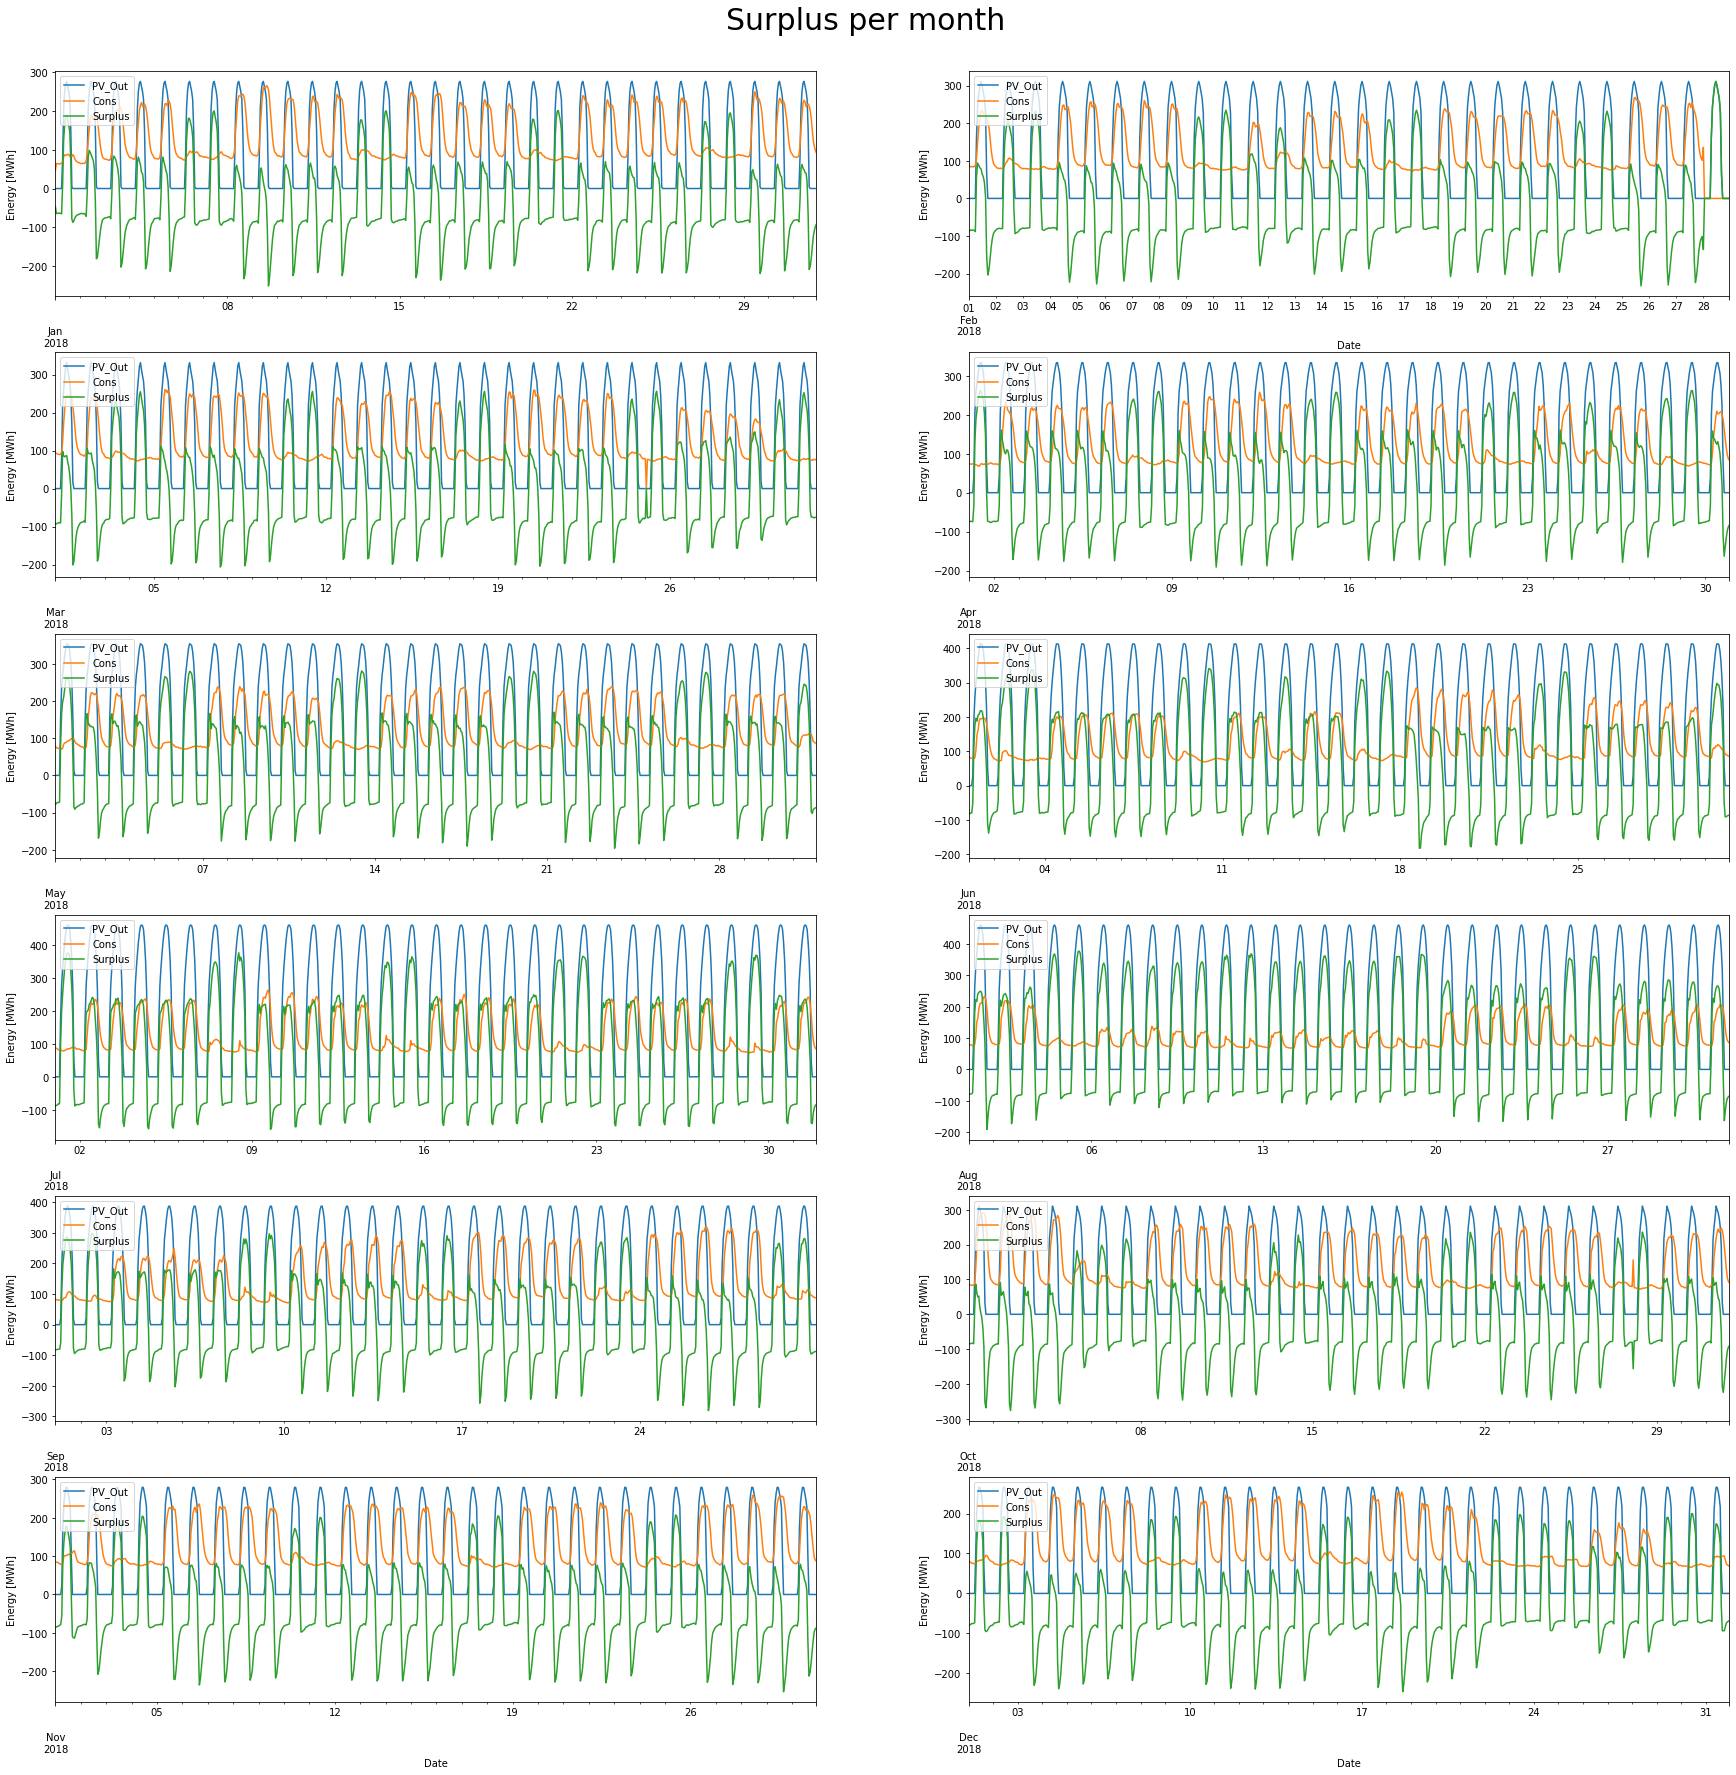

In [10]:
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.25)
plt.suptitle("Surplus per month", fontsize=30, y=0.91)

for n, i in enumerate(range(1,13)):
    ax = plt.subplot(6, 2, n + 1)
    dados_consumo[['PV_Out','Cons','Surplus']].loc[(dados_consumo.index.month==i)].plot(ax=ax, label="PV Output")
    plt.legend(loc="upper left")
    plt.ylabel("Energy [MWh]")

Text(0, 0.5, 'Energy [MWh]')

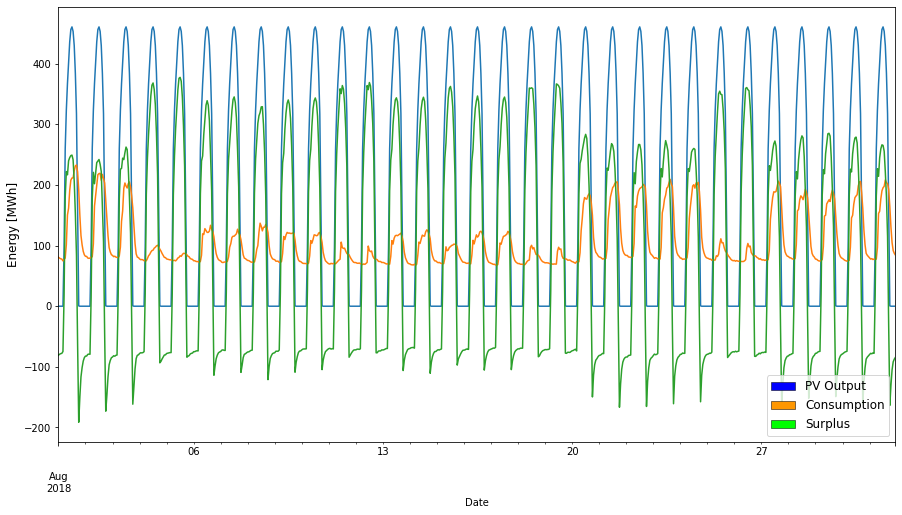

In [11]:
dados_consumo[['PV_Out','Cons','Surplus']].loc[(dados_consumo.index.month==8)].plot()
plt.gcf().set_size_inches(15, 8) 

pv_out = mpatches.Patch(facecolor='#0000FF', label='PV Output', linewidth = 0.5, edgecolor = 'black')
cons = mpatches.Patch(facecolor='#ff9700', label = 'Consumption', linewidth = 0.5, edgecolor = 'black')
surplus = mpatches.Patch(facecolor='#00FF00', label = 'Surplus', linewidth = 0.5, edgecolor = 'black')
legend = plt.legend(handles=[pv_out,cons,surplus], loc=4, fontsize='large', fancybox=True)

plt.ylabel("Energy [MWh]",fontsize='large')

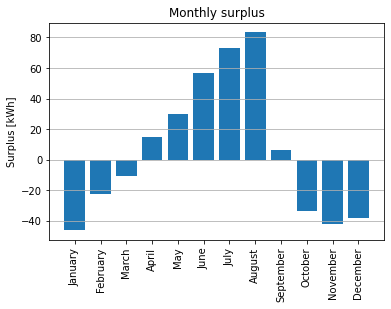

January: -46.18 kWh
February: -22.83 kWh
March: -10.48 kWh
April: 14.54 kWh
May: 29.84 kWh
June: 56.79 kWh
July: 72.86 kWh
August: 83.20 kWh
September: 6.31 kWh
October: -33.57 kWh
November: -42.12 kWh
December: -38.31 kWh


In [12]:
average_surplus = dados_consumo['Surplus'].groupby(dados_consumo.index.month).mean()

plt.xticks(rotation=90)
plt.gca().yaxis.grid(True)
plt.bar(month_name[1:],average_surplus)
plt.title("Monthly surplus")
plt.ylabel("Surplus [kWh]")
plt.show()


for i in range(1,13):
    print(f"{month_name[i]}: {average_surplus[i]:.2f} kWh")

In [13]:
dados_consumo.to_csv('dados/dados.csv')

### Interactive surplus visualization

In [437]:
months = dados_irradiacao["mes"].unique()
def plot_surplus(efficiency,area,performance_rate,month,mode):

    conso = dados_consumo.loc[dados_consumo.index.month == month,:]
    conso = conso.groupby(conso.index.hour).mean()

    row_mask = dados_irradiacao["mes"] == months[month-1]
    irrad = dados_irradiacao.loc[row_mask,:].groupby(dados_irradiacao["hora"]).mean()

    conso.loc[:,'PV_Out'] = irrad["Irradiacao"]*efficiency*performance_rate*area

    conso.loc[:,'Surplus']=conso['PV_Out'] - conso['Cons']

    # Choose plot type
    if mode == 0:
        conso[['PV_Out','Cons','Surplus']].plot()
    else:
        conso[['PV_Out','Cons','Surplus']].plot.bar()
        
    plt.gcf().set_size_inches(12, 7) 
    plt.gca().yaxis.grid(True)
  
    pv_out = mpatches.Patch(facecolor='#0000FF', label='PV Output', linewidth = 0.5, edgecolor = 'black')
    cons = mpatches.Patch(facecolor='#ff9700', label = 'Consumption', linewidth = 0.5, edgecolor = 'black')
    surplus = mpatches.Patch(facecolor='#00FF00', label = 'Surplus', linewidth = 0.5, edgecolor = 'black')
    legend = plt.legend(handles=[pv_out,cons,surplus], loc="upper right", fontsize='large', fancybox=True)

    # labels
    plt.title(f"Average hourly surplus in {month_name[month]}",fontsize='large')
    plt.xlabel("Hours",fontsize='large')
    plt.ylabel("Energy [MWh]",fontsize='large')


In [440]:
area_slider = widgets.IntSlider(min=0, max=10E4, step=10, value=4317,continuous_update = True,description="Area [m^2]",layout=Layout( width='auto'))
eff_slider = widgets.FloatSlider(min=0.0, max=1.0,step = 0.01,value=0.15,continuous_update = True,description="Efficiency",layout=Layout( width='auto'))
pr_slider = widgets.FloatSlider(min=0.0, max=1.0,step = 0.01,value=0.95,continuous_update = True,description="Performance (eta)",layout=Layout( width='auto'))
month_dropdown = widgets.Dropdown(options = zip(month_name[1:],range(1,13)),description="Month",layout=Layout( width='60%'))
chart_type = widgets.RadioButtons(options=[('Line plot',0), ('Bar plot',1)], continuous_update = True,description='Graph type:',disabled=False)

result = interactive(plot_surplus,area = area_slider,
                      efficiency = eff_slider,
                      performance_rate = pr_slider,
                      month = month_dropdown,
                      mode = chart_type
            )


In [456]:
box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_content='stretch',
                    width='100%',
                    )
box_sliders = Box(children=[area_slider,eff_slider,pr_slider], layout=box_layout) 
box = Box(children=[month_dropdown,box_sliders,chart_type], layout=box_layout)


grid = GridspecLayout(3,5)
grid[:,0:3] = result.children[-1] # the actual plot
grid[1:,3:] = box # sliders


In [457]:
display(grid)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001'), outputs=({'output_type': 'display_data',…

# Predicting Surplus

In [ ]:
fixed_slow = 0.03
time_slow = 0.02
energy_slow = 0.009

fixed_fast = 0.038
time_fast = 0.077
energy_fast = 0.018

peak = 0.2816
mid = 0.1459
off = 0.0702

iec = 0.001

iva = 0.23

In [ ]:
n = 0.5 
bateria = 82*n
tempo_slow = (11 * 60)*n
tempo_fast = ((3 * 60) + 45)*n

In [ ]:
preco_slow_peak = fixed_slow + (time_slow * tempo_slow) + (energy_slow*bateria) + (peak*bateria) + (iec*bateria)
preco_slow_peak = preco_slow_peak + preco_slow_peak*iva

preco_slow_mid = fixed_slow + (time_slow * tempo_slow) + (energy_slow*bateria) + (mid*bateria) + (iec*bateria)
preco_slow_mid = preco_slow_mid + preco_slow_mid*iva

preco_slow_off = fixed_slow + (time_slow * tempo_slow) + (energy_slow*bateria) + (off*bateria) + (iec*bateria)
preco_slow_off = preco_slow_off + preco_slow_off*iva

print(' (Slow Charging)\nPeak -',preco_slow_peak,'\nMid-peak -', preco_slow_mid, '\nOff-peak -' ,preco_slow_off)

Preços (Slow Charging)
Peak - 22.860288000000004 
Mid-peak - 16.016937000000002 
Off-peak - 12.199386


In [ ]:
preco_fast_peak = fixed_fast + (time_fast * tempo_fast) + (energy_fast*bateria) + (peak*bateria) + (iec*bateria)
preco_fast_peak = preco_fast_peak + preco_fast_peak*iva

preco_fast_mid = fixed_fast + (time_fast * tempo_fast) + (energy_fast*bateria) + (mid*bateria) + (iec*bateria)
preco_fast_mid = preco_slow_mid + preco_slow_mid*iva

preco_fast_off = fixed_fast + (time_fast * tempo_fast) + (energy_fast*bateria) + (off*bateria) + (iec*bateria)
preco_fast_off = preco_fast_off + preco_fast_off*iva

print('(Fast Charging)\nPeak -', preco_fast_peak,'\nMid-peak -',preco_fast_mid,'\nOff-peak -',preco_fast_off)

Preços (Fast Charging)
Peak - 25.860872999999998 
Mid-peak - 19.70083251 
Off-peak - 15.199971


In [ ]:
a = 0.75

print('(GreenCharge - Slow charging)\nPeak -',preco_slow_peak*a,'\nMid-peak -',preco_slow_mid*a,'\nOff-peak -',preco_slow_off*a,'\n')
print('(GreenCharge - Fast charging)\nPeak -',preco_fast_peak*a,'\nMid-peak -',preco_fast_mid*a,'\nOff-peak -',preco_fast_off*a)